# SETUP AND INSTALLATION

In [ ]:

!pip install roboflow kagglehub --quiet

import os
import pandas as pd
import numpy as np
import tensorflow as tf
from roboflow import Roboflow
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
from google.colab import files
from google.colab.patches import cv2_imshow

print("done..")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 28.6 MB/s eta 0:00:00
done..


# download datasets

In [ ]:
# --- REVISED DOWNLOAD CELL ---

# Dictionary to hold the paths to our downloaded data
paths = {}

try:
    # --- Roboflow Downloads ---
    # Make sure you've run !pip install roboflow and imported it
    from roboflow import Roboflow
    rf = Roboflow(api_key="YOUR_ROBOFLOW_API_KEY") # Replace with your key

    print("--- Downloading Original Datasets ---")
    print("  -> Downloading Graffiti dataset...")
    project = rf.workspace("hruts-workspace").project("graffiti-l6az9")
    dataset = project.version(1).download("yolov8")
    paths['graffiti'] = dataset.location

    print("  -> Downloading Potholes (Original) dataset...")
    project = rf.workspace("road-holes").project("road-holes-iow4h")
    dataset = project.version(1).download("yolov8")
    paths['potholes'] = dataset.location

    print("  -> Downloading Damaged Construction (Concrete) dataset...")
    project = rf.workspace("road-ywxxe").project("concrete-pugqq")
    dataset = project.version(3).download("yolov8")
    paths['concrete'] = dataset.location

    print("  -> Downloading Trash (Original) dataset...")
    project = rf.workspace("trash-drone").project("domestic-trash-ryw1h")
    dataset = project.version(2).download("yolov8")
    paths['trash'] = dataset.location

    print("  -> Downloading Illegal Parking (Original) dataset...")
    project = rf.workspace("parking-amu50").project("illegal-parking")
    dataset = project.version(5).download("yolov8")
    paths['parking'] = dataset.location

    print("  -> Downloading Damaged Signs (HIND) dataset...")
    project = rf.workspace("road-inspection").project("damaged-signs-hind")
    dataset = project.version(2).download("yolov8")
    paths['signs_hind'] = dataset.location

    print("\n--- Downloading Additional Datasets for Augmentation ---")
    print("  -> Downloading NEW Illegal Parking dataset...")
    project = rf.workspace("hao-61fh1").project("illegal-parking-xtkyr")
    dataset = project.version(1).download("yolov8")
    paths['parking_new'] = dataset.location

    print("  -> Downloading NEW Potholes dataset...")
    project = rf.workspace("evansworkspace").project("pothole-ek")
    dataset = project.version(1).download("yolov8")
    paths['potholes_new'] = dataset.location

    print("  -> Downloading NEW Domestic Trash dataset...")
    project = rf.workspace("datacluster-labs-agryi").project("domestic-trash")
    dataset = project.version(1).download("yolov8")
    paths['trash_new'] = dataset.location


    print("\n All datasets downloaded successfully!")
    for name, path in paths.items():
        print(f"  - {name}: {path}")

except Exception as e:
    print(f"\n An error occurred during download: {e}")

  -> Downloading Graffiti dataset...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Graffiti-1 in yolov8:: 100%|██████████| 4268/4268 [00:00<00:00, 6226.28it/s]


  -> Downloading Damaged Signs (Multi-Label) dataset...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Damaged-Signs-Multi-label-3 in multiclass:: 100%|██████████| 1801/1801 [00:00<00:00, 3990.16it/s]

  -> Downloading Illegal Parking dataset...
loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to Illegal-Parking-5 in yolov8:: 100%|██████████| 220/220 [00:00<00:00, 8090.58it/s]

  -> Downloading Damaged Signs (HIND) dataset...
loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to damaged-signs-Hind-2 in yolov8:: 100%|██████████| 4830/4830 [00:00<00:00, 7699.56it/s]

  -> Downloading Potholes dataset...
loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to Road-holes-1 in yolov8:: 100%|██████████| 378/378 [00:00<00:00, 5409.42it/s]

  -> Downloading Damaged Construction (Concrete) dataset...
loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to concrete-3 in yolov8:: 100%|██████████| 1992/1992 [00:00<00:00, 3542.84it/s]


  -> Downloading  trash  dataset...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Domestic-trash-2 in yolov8:: 100%|██████████| 508/508 [00:00<00:00, 6609.32it/s]


 downloaded..!
  - graffiti: /content/Graffiti-1
  - signs_multiclass: /content/Damaged-Signs-Multi-label-3
  - parking: /content/Illegal-Parking-5
  - signs_hind: /content/damaged-signs-Hind-2
  - potholes: /content/Road-holes-1
  - concrete: /content/concrete-3
  - trash: /content/Domestic-trash-2


# Process dataset

In [ ]:

all_data = []

def process_yolo_folder(path, label, data_list):
    """Processes folders with a simple 'images' and 'labels' structure."""
    image_path = os.path.join(path, "train/images")
    print(f"  -> Processing: {image_path} for label: {label}")
    try:
        if not os.path.exists(image_path):
            print(f"    --> WARNING: Path does not exist. Skipping.")
            return
        for img_file in os.listdir(image_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                data_list.append({'filepath': os.path.join(image_path, img_file), 'label': label})
    except Exception as e:
        print(f"    --> ERROR processing {path}: {e}")

# Process datasets downloaded in YOLOv8 format
process_yolo_folder(paths.get('graffiti'), "Vandalism_Graffiti", all_data)
process_yolo_folder(paths.get('parking'), "Parking_Issues_Illegal_Parking", all_data)
process_yolo_folder(paths.get('signs_hind'), "Road_Issues_Damaged_Sign", all_data)
process_yolo_folder(paths.get('potholes'), "Road_Issues_Pothole", all_data)
process_yolo_folder(paths.get('concrete'), "Infrastructure_Damage_Concrete", all_data)
process_yolo_folder(paths.get('trash'), "Domestic_trash", all_data)


# Create the initial raw DataFrame
df_raw = pd.DataFrame(all_data)

if not df_raw.empty:
    print("\n Initial DataFrame created successfully.")
    print(f"Total raw images found: {len(df_raw)}")
    print("\nInitial (Imbalanced) Label Distribution:")
    print(df_raw['label'].value_counts())
else:
    print("\n Error: No data was loaded. Please check the download paths.")

  -> Processing: /content/Graffiti-1/train/images for label: Vandalism_Graffiti
  -> Processing: /content/Illegal-Parking-5/train/images for label: Parking_Issues_Illegal_Parking
  -> Processing: /content/damaged-signs-Hind-2/train/images for label: Road_Issues_Damaged_Sign
  -> Processing: /content/Road-holes-1/train/images for label: Road_Issues_Pothole
  -> Processing: /content/concrete-3/train/images for label: Infrastructure_Damage_Concrete
  -> Processing: /content/Domestic-trash-2/train/images for label: Domestic_trash

 Initial DataFrame created successfully.
Total raw images found: 5123

Initial (Imbalanced) Label Distribution:
label
Road_Issues_Damaged_Sign          2140
Vandalism_Graffiti                1704
Infrastructure_Damage_Concrete     891
Domestic_trash                     173
Road_Issues_Pothole                128
Parking_Issues_Illegal_Parking      87
Name: count, dtype: int64


# Balanced using oversampling

In [ ]:
if not df_raw.empty:
    # Find the size of the largest class
    max_size = df_raw['label'].value_counts().max()
    print(f"Target size for each class will be: {max_size}")

    # Create a new, balanced DataFrame
    df_balanced_list = []
    for class_label in df_raw['label'].unique():
        df_class = df_raw[df_raw['label'] == class_label]
        df_class_oversampled = resample(df_class,
                                        replace=True, # Create copies of images
                                        n_samples=max_size,
                                        random_state=42) # for reproducibility
        df_balanced_list.append(df_class_oversampled)

    # Combine the oversampled classes into a single DataFrame
    df_balanced = pd.concat(df_balanced_list)

    print("\nNew balanced label distribution:")
    print(df_balanced['label'].value_counts())
    print(f"\nTotal images for training after balancing: {len(df_balanced)}")
else:
    print("\nSkipping balancing because the initial dataframe is empty.")

Target size for each class will be: 2140

New balanced label distribution:
label
Vandalism_Graffiti                2140
Parking_Issues_Illegal_Parking    2140
Road_Issues_Damaged_Sign          2140
Road_Issues_Pothole               2140
Infrastructure_Damage_Concrete    2140
Domestic_trash                    2140
Name: count, dtype: int64

Total images for training after balancing: 12840


#  PREPARE DATA FOR TRAINING

In [ ]:
if 'df_balanced' in locals() and not df_balanced.empty:
    print("\n Splitting data and creating Image Data Generators...")

    # Split data with stratification
    train_df, val_df = train_test_split(
        df_balanced,
        test_size=0.2, # 20% for validation
        random_state=42,
        stratify=df_balanced['label']
    )

    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")

    # Create Data Generators with Augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator(rescale=1./255) # No augmentation for validation

    IMG_SIZE = (128, 128)
    BATCH_SIZE = 64 #### batch size

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepath',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filepath',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    print("\n Data generators created successfully.")

else:
    print("\nSkipping data preparation  the balanced dataframe is not available.")


 Splitting data and creating Image Data Generators...
Training samples: 10272
Validation samples: 2568
Found 10272 validated image filenames belonging to 6 classes.
Found 2568 validated image filenames belonging to 6 classes.

 Data generators created successfully.


# BUILD AND COMPILE THE MODEL

In [ ]:
if 'train_generator' in locals():
    print("\n  Building the CNN Model...")

    num_classes = len(df_balanced['label'].unique())
    print(f"Number of classes for output layer: {num_classes}")

    model = tf.keras.models.Sequential([
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5), # Dropout for regularization
        tf.keras.layers.Dense(num_classes, activation='softmax') # Softmax for multi-class
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()
else:
    print("\nSkipping model building because data generators are not ready.")


  Building the CNN Model...
Number of classes for output layer: 6


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,941,894 (49.37 MB)

 Trainable params: 12,941,894 (49.37 MB)

 Non-trainable params: 0 (0.00 B)

# train model

In [ ]:
if 'model' in locals():
    print("\nStarting Model Training...")

    # Callbacks for smarter training
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('MlArtist_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]

    EPOCHS = 30 # Train epochs

    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks
    )

else:
    print("\nSkipping training because the model was not built.")


Starting Model Training...


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.3884 - loss: 1.5177

161/161 ━━━━━━━━━━━━━━━━━━━━ 86s 491ms/step - accuracy: 0.3891 - loss: 1.5160 - val_accuracy: 0.6523 - val_loss: 0.8738 - learning_rate: 0.0010
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.6786 - loss: 0.8346

161/161 ━━━━━━━━━━━━━━━━━━━━ 73s 454ms/step - accuracy: 0.6788 - loss: 0.8341 - val_accuracy: 0.7473 - val_loss: 0.7031 - learning_rate: 0.0010
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7833 - loss: 0.5988

161/161 ━━━━━━━━━━━━━━━━━━━━ 73s 452ms/step - accuracy: 0.7833 - loss: 0.5986 - val_accuracy: 0.8594 - val_loss: 0.3927 - learning_rate: 0.0010
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 73s 453ms/step - accuracy: 0.8235 - loss: 0.4660 - val_accuracy: 0.8372 - val_loss: 0.4630 - learning_rate: 0.0010
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8469 - loss: 0.4043

161/161 ━━━━━━━━━━━━━━━━━━━━ 75s 464ms/step - accuracy: 0.8469 - loss: 0.4043 - val_accuracy: 0.8921 - val_loss: 0.3095 - learning_rate: 0.0010
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8634 - loss: 0.3653

161/161 ━━━━━━━━━━━━━━━━━━━━ 70s 435ms/step - accuracy: 0.8635 - loss: 0.3652 - val_accuracy: 0.8991 - val_loss: 0.2814 - learning_rate: 0.0010
Epoch 7/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8721 - loss: 0.3518

161/161 ━━━━━━━━━━━━━━━━━━━━ 84s 448ms/step - accuracy: 0.8721 - loss: 0.3518 - val_accuracy: 0.9120 - val_loss: 0.2342 - learning_rate: 0.0010
Epoch 8/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9023 - loss: 0.2734

161/161 ━━━━━━━━━━━━━━━━━━━━ 72s 445ms/step - accuracy: 0.9023 - loss: 0.2735 - val_accuracy: 0.9322 - val_loss: 0.1870 - learning_rate: 0.0010
Epoch 9/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 74s 461ms/step - accuracy: 0.9016 - loss: 0.2735 - val_accuracy: 0.9003 - val_loss: 0.3606 - learning_rate: 0.0010
Epoch 10/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 79s 441ms/step - accuracy: 0.9134 - loss: 0.2404 - val_accuracy: 0.9030 - val_loss: 0.3312 - learning_rate: 0.0010
Epoch 11/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 71s 442ms/step - accuracy: 0.9172 - loss: 0.2171 - val_accuracy: 0.9280 - val_loss: 0.2144 - learning_rate: 0.0010
Epoch 12/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 71s 440ms/step - accuracy: 0.9397 - loss: 0.1751 - val_accuracy: 0.9280 - val_loss: 0.1991 - learning_rate: 2.0000e-04
Epoch 13/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9494 - loss: 0.1441

161/161 ━━━━━━━━━━━━━━━━━━━━ 76s 470ms/step - accuracy: 0.9494 - loss: 0.1441 - val_accuracy: 0.9467 - val_loss: 0.1592 - learning_rate: 2.0000e-04
Epoch 14/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 82s 469ms/step - accuracy: 0.9544 - loss: 0.1287 - val_accuracy: 0.9256 - val_loss: 0.2164 - learning_rate: 2.0000e-04
Epoch 15/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9543 - loss: 0.1300

161/161 ━━━━━━━━━━━━━━━━━━━━ 72s 446ms/step - accuracy: 0.9543 - loss: 0.1299 - val_accuracy: 0.9681 - val_loss: 0.0983 - learning_rate: 2.0000e-04
Epoch 16/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 71s 439ms/step - accuracy: 0.9561 - loss: 0.1199 - val_accuracy: 0.9533 - val_loss: 0.1521 - learning_rate: 2.0000e-04
Epoch 17/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 73s 454ms/step - accuracy: 0.9594 - loss: 0.1193 - val_accuracy: 0.9408 - val_loss: 0.2014 - learning_rate: 2.0000e-04
Epoch 18/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 74s 462ms/step - accuracy: 0.9604 - loss: 0.1113 - val_accuracy: 0.9494 - val_loss: 0.1700 - learning_rate: 2.0000e-04
Epoch 19/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 72s 446ms/step - accuracy: 0.9631 - loss: 0.1002 - val_accuracy: 0.9611 - val_loss: 0.1239 - learning_rate: 4.0000e-05
Epoch 20/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 75s 465ms/step - accuracy: 0.9651 - loss: 0.1015 - val_accuracy: 0.9498 - val_loss: 0.1471 - learning_rate: 4.0000e-05


# EVALUATE AND VISUALIZE


 Step 8: Plotting training history...


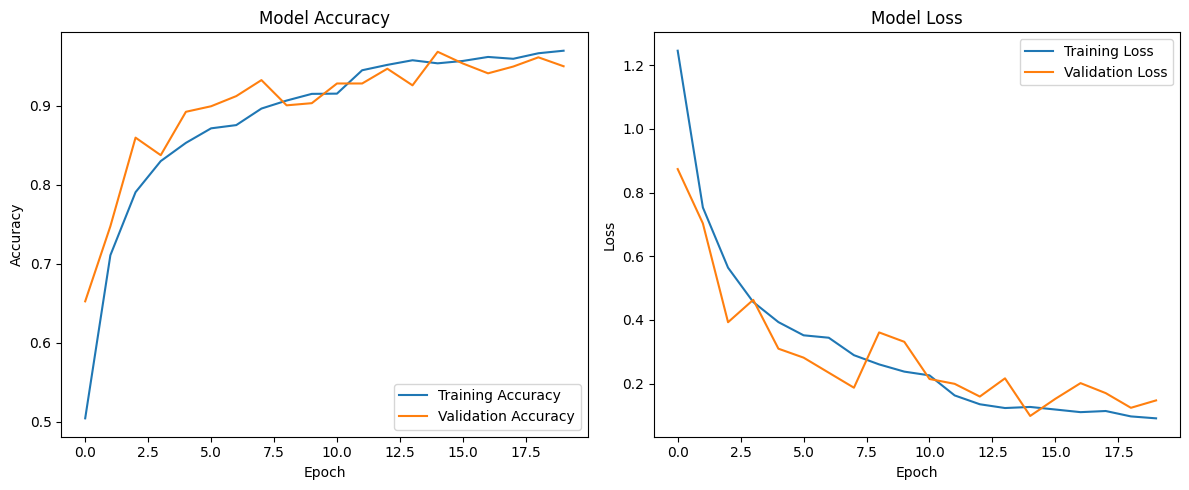


Final evaluation on validation data:


  -> Validation Accuracy: 96.81%
  -> Validation Loss: 0.0983

Classification Report:
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step
                                precision    recall  f1-score   support

                Domestic_trash       0.98      1.00      0.99       428
Infrastructure_Damage_Concrete       1.00      0.99      0.99       428
Parking_Issues_Illegal_Parking       0.99      0.98      0.99       428
      Road_Issues_Damaged_Sign       0.96      0.93      0.95       428
           Road_Issues_Pothole       0.97      1.00      0.98       428
            Vandalism_Graffiti       0.91      0.90      0.91       428

                      accuracy                           0.97      2568
                     macro avg       0.97      0.97      0.97      2568
                  weighted avg       0.97      0.97      0.97      2568



In [ ]:
from sklearn.metrics import classification_report

if 'history' in locals():
    print("\n Step 8: Plotting training history...")

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Final evaluation of the best model
    print("\nFinal evaluation on validation data:")
    # Load the best performing model saved by ModelCheckpoint
    best_model = tf.keras.models.load_model('MlArtist_model.h5')
    val_loss, val_accuracy = best_model.evaluate(validation_generator, verbose=0)
    print(f"  -> Validation Accuracy: {val_accuracy*100:.2f}%")
    print(f"  -> Validation Loss: {val_loss:.4f}")

    # Calculate F1 score
    print("\nClassification Report:")
    # Get predictions from the validation generator
    y_pred = best_model.predict(validation_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    # Get true labels from the validation generator
    y_true = validation_generator.classes
    # Get class labels
    class_labels = list(validation_generator.class_indices.keys())

    print(classification_report(y_true, y_pred_classes, target_names=class_labels))


else:
    print("\nSkipping evaluation because training was not completed.")

#save model as pickle

In [ ]:
import pickle


pickle_filename = 'MlArtist_FinalModel.pkl'

print(f"Saving model to {pickle_filename}...")

with open(pickle_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(" Model successfully saved as a pickle file.")

Saving model to MlArtist_FinalModel.pkl...
 Model successfully saved as a pickle file.


# prediction

Best trained model loaded successfully.

Ready to predict! Use the button below to upload an image.


Saving fly-tipped-trash.avif to fly-tipped-trash.avif

--- Analyzing 'fly-tipped-trash.avif' ---


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step

 Anonymized Input Image:


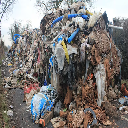


 Prediction Result:
  - Main Category: Vandalism
  - Sub Category:  Graffiti
  - Confidence:    60.94%


In [ ]:

try:
    # Load the best performing model saved by ModelCheckpoint
    best_model = tf.keras.models.load_model('MlArtist_model.h5')
    print("Best trained model loaded successfully.")
except Exception as e:
    print(f" Error loading model: {e}")
    best_model = None

# --- Anonymization Function (with corrections) ---
# Download the face detection model if needed
if not os.path.exists('haarcascade_frontalface_default.xml'):
    !wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def anonymize_image(img_array):
    # CORRECTED LINE: Used COLOR_RGB2BGR
    img_bgr = cv2.cvtColor(img_array.astype(np.uint8), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    for (x, y, w, h) in faces:
        face_roi = img_bgr[y:y+h, x:x+w]
        blurred_face = cv2.GaussianBlur(face_roi, (99, 99), 30)
        img_bgr[y:y+h, x:x+w] = blurred_face
    # CORRECTED LINE: Used COLOR_BGR2RGB
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# --- Prediction Function (with corrections) ---
def predict_on_upload(model_to_use, train_gen):
    if model_to_use is None:
        print("Model is not loaded. Cannot predict.")
        return

    # Create the label map from the training generator
    class_indices = train_gen.class_indices
    labels_map = {v: k for k, v in class_indices.items()}

    # Upload files
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\n--- Analyzing '{filename}' ---")
        try:
            img = tf.keras.preprocessing.image.load_img(filename, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            anonymized_array = anonymize_image(img_array)
            img_batch = np.expand_dims(anonymized_array, axis=0)
            img_preprocessed = img_batch / 255.0
            prediction = model_to_use.predict(img_preprocessed)

            predicted_index = np.argmax(prediction[0])
            predicted_label = labels_map[predicted_index]
            confidence = np.max(prediction[0]) * 100

            main_category, sub_category = predicted_label.split('_', 1)

            print("\n Anonymized Input Image:")
            # CORRECTED LINE: Used COLOR_RGB2BGR
            display_img = cv2.cvtColor(anonymized_array, cv2.COLOR_RGB2BGR)
            cv2_imshow(display_img)

            print(f"\n Prediction Result:")
            print(f"  - Main Category: {main_category}")
            print(f"  - Sub Category:  {sub_category.replace('_', ' ')}")
            print(f"  - Confidence:    {confidence:.2f}%")
        except Exception as e:
            print(f"Error processing {filename}: {e}")


# --- Run Prediction ---
if best_model and 'train_generator' in locals():
    print("\nReady to predict! Use the button below to upload an image.")
    predict_on_upload(best_model, train_generator)
else:
    print("\nCannot run prediction. Ensure model was trained and data generators were created.")


Ready to predict! Use the button below to upload an image.


Saving istockphoto-538686713-612x612.jpg to istockphoto-538686713-612x612.jpg

--- Analyzing 'istockphoto-538686713-612x612.jpg' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

 Anonymized Input Image:


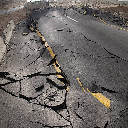


 Prediction Result:
  - Main Category: Road
  - Sub Category:  Issues Pothole
  - Confidence:    99.62%


In [ ]:

# --- Prediction Function (with corrections) ---
def predict_on_upload(model_to_use, train_gen):
    if model_to_use is None:
        print("Model is not loaded. Cannot predict.")
        return

    # Create the label map from the training generator
    class_indices = train_gen.class_indices
    labels_map = {v: k for k, v in class_indices.items()}

    # Upload files
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\n--- Analyzing '{filename}' ---")
        try:
            img = tf.keras.preprocessing.image.load_img(filename, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            anonymized_array = anonymize_image(img_array)
            img_batch = np.expand_dims(anonymized_array, axis=0)
            img_preprocessed = img_batch / 255.0
            prediction = model_to_use.predict(img_preprocessed)

            predicted_index = np.argmax(prediction[0])
            predicted_label = labels_map[predicted_index]
            confidence = np.max(prediction[0]) * 100

            main_category, sub_category = predicted_label.split('_', 1)

            print("\n Anonymized Input Image:")
            # CORRECTED LINE: Used COLOR_RGB2BGR
            display_img = cv2.cvtColor(anonymized_array, cv2.COLOR_RGB2BGR)
            cv2_imshow(display_img)

            print(f"\n Prediction Result:")
            print(f"  - Main Category: {main_category}")
            print(f"  - Sub Category:  {sub_category.replace('_', ' ')}")
            print(f"  - Confidence:    {confidence:.2f}%")
        except Exception as e:
            print(f" Error processing {filename}: {e}")


# --- Run Prediction ---
if best_model and 'train_generator' in locals():
    print("\nReady to predict! Use the button below to upload an image.")
    predict_on_upload(best_model, train_generator)
else:
    print("\nCannot run prediction. Ensure model was trained and data generators were created.")


Ready to predict! Use the button below to upload an image.


Saving images (1).jpg to images (1).jpg

--- Analyzing 'images (1).jpg' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

 Anonymized Input Image:


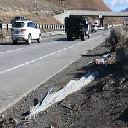


 Prediction Result:
  - Main Category: Road
  - Sub Category:  Issues Pothole
  - Confidence:    99.88%


In [ ]:

# --- Prediction Function (with corrections) ---
def predict_on_upload(model_to_use, train_gen):
    if model_to_use is None:
        print("Model is not loaded. Cannot predict.")
        return

    # Create the label map from the training generator
    class_indices = train_gen.class_indices
    labels_map = {v: k for k, v in class_indices.items()}

    # Upload files
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\n--- Analyzing '{filename}' ---")
        try:
            img = tf.keras.preprocessing.image.load_img(filename, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            anonymized_array = anonymize_image(img_array)
            img_batch = np.expand_dims(anonymized_array, axis=0)
            img_preprocessed = img_batch / 255.0
            prediction = model_to_use.predict(img_preprocessed)

            predicted_index = np.argmax(prediction[0])
            predicted_label = labels_map[predicted_index]
            confidence = np.max(prediction[0]) * 100

            main_category, sub_category = predicted_label.split('_', 1)

            print("\n Anonymized Input Image:")
            # CORRECTED LINE: Used COLOR_RGB2BGR
            display_img = cv2.cvtColor(anonymized_array, cv2.COLOR_RGB2BGR)
            cv2_imshow(display_img)

            print(f"\n Prediction Result:")
            print(f"  - Main Category: {main_category}")
            print(f"  - Sub Category:  {sub_category.replace('_', ' ')}")
            print(f"  - Confidence:    {confidence:.2f}%")
        except Exception as e:
            print(f" Error processing {filename}: {e}")


# --- Run Prediction ---
if best_model and 'train_generator' in locals():
    print("\nReady to predict! Use the button below to upload an image.")
    predict_on_upload(best_model, train_generator)
else:
    print("\nCannot run prediction. Ensure model was trained and data generators were created.")


Ready to predict! Use the button below to upload an image.


Saving images (2).jpg to images (2).jpg

--- Analyzing 'images (2).jpg' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

 Anonymized Input Image:


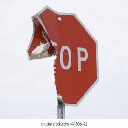


 Prediction Result:
  - Main Category: Road
  - Sub Category:  Issues Damaged Sign
  - Confidence:    99.54%


In [ ]:

# --- Prediction Function (with corrections) ---
def predict_on_upload(model_to_use, train_gen):
    if model_to_use is None:
        print("Model is not loaded. Cannot predict.")
        return

    # Create the label map from the training generator
    class_indices = train_gen.class_indices
    labels_map = {v: k for k, v in class_indices.items()}

    # Upload files
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\n--- Analyzing '{filename}' ---")
        try:
            img = tf.keras.preprocessing.image.load_img(filename, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            anonymized_array = anonymize_image(img_array)
            img_batch = np.expand_dims(anonymized_array, axis=0)
            img_preprocessed = img_batch / 255.0
            prediction = model_to_use.predict(img_preprocessed)

            predicted_index = np.argmax(prediction[0])
            predicted_label = labels_map[predicted_index]
            confidence = np.max(prediction[0]) * 100

            main_category, sub_category = predicted_label.split('_', 1)

            print("\n Anonymized Input Image:")
            # CORRECTED LINE: Used COLOR_RGB2BGR
            display_img = cv2.cvtColor(anonymized_array, cv2.COLOR_RGB2BGR)
            cv2_imshow(display_img)

            print(f"\n Prediction Result:")
            print(f"  - Main Category: {main_category}")
            print(f"  - Sub Category:  {sub_category.replace('_', ' ')}")
            print(f"  - Confidence:    {confidence:.2f}%")
        except Exception as e:
            print(f" Error processing {filename}: {e}")


# --- Run Prediction ---
if best_model and 'train_generator' in locals():
    print("\nReady to predict! Use the button below to upload an image.")
    predict_on_upload(best_model, train_generator)
else:
    print("\nCannot run prediction. Ensure model was trained and data generators were created.")


Ready to predict! Use the button below to upload an image.


Saving 100_3143.jpg to 100_3143.jpg

--- Analyzing '100_3143.jpg' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

 Anonymized Input Image:


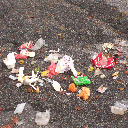


 Prediction Result:
  - Main Category: Domestic
  - Sub Category:  trash
  - Confidence:    100.00%


In [ ]:

# --- Prediction Function (with corrections) ---
def predict_on_upload(model_to_use, train_gen):
    if model_to_use is None:
        print("Model is not loaded. Cannot predict.")
        return

    # Create the label map from the training generator
    class_indices = train_gen.class_indices
    labels_map = {v: k for k, v in class_indices.items()}

    # Upload files
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\n--- Analyzing '{filename}' ---")
        try:
            img = tf.keras.preprocessing.image.load_img(filename, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            anonymized_array = anonymize_image(img_array)
            img_batch = np.expand_dims(anonymized_array, axis=0)
            img_preprocessed = img_batch / 255.0
            prediction = model_to_use.predict(img_preprocessed)

            predicted_index = np.argmax(prediction[0])
            predicted_label = labels_map[predicted_index]
            confidence = np.max(prediction[0]) * 100

            main_category, sub_category = predicted_label.split('_', 1)

            print("\n Anonymized Input Image:")
            # CORRECTED LINE: Used COLOR_RGB2BGR
            display_img = cv2.cvtColor(anonymized_array, cv2.COLOR_RGB2BGR)
            cv2_imshow(display_img)

            print(f"\n Prediction Result:")
            print(f"  - Main Category: {main_category}")
            print(f"  - Sub Category:  {sub_category.replace('_', ' ')}")
            print(f"  - Confidence:    {confidence:.2f}%")
        except Exception as e:
            print(f" Error processing {filename}: {e}")


# --- Run Prediction ---
if best_model and 'train_generator' in locals():
    print("\nReady to predict! Use the button below to upload an image.")
    predict_on_upload(best_model, train_generator)
else:
    print("\nCannot run prediction. Ensure model was trained and data generators were created.")


Ready to predict! Use the button below to upload an image.


Saving images.jpg to images.jpg

--- Analyzing 'images.jpg' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

 Anonymized Input Image:


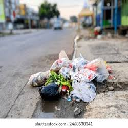


 Prediction Result:
  - Main Category: Road
  - Sub Category:  Issues Pothole
  - Confidence:    76.92%


In [ ]:

# --- Prediction Function (with corrections) ---
def predict_on_upload(model_to_use, train_gen):
    if model_to_use is None:
        print("Model is not loaded. Cannot predict.")
        return

    # Create the label map from the training generator
    class_indices = train_gen.class_indices
    labels_map = {v: k for k, v in class_indices.items()}

    # Upload files
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\n--- Analyzing '{filename}' ---")
        try:
            img = tf.keras.preprocessing.image.load_img(filename, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            anonymized_array = anonymize_image(img_array)
            img_batch = np.expand_dims(anonymized_array, axis=0)
            img_preprocessed = img_batch / 255.0
            prediction = model_to_use.predict(img_preprocessed)

            predicted_index = np.argmax(prediction[0])
            predicted_label = labels_map[predicted_index]
            confidence = np.max(prediction[0]) * 100

            main_category, sub_category = predicted_label.split('_', 1)

            print("\n Anonymized Input Image:")
            # CORRECTED LINE: Used COLOR_RGB2BGR
            display_img = cv2.cvtColor(anonymized_array, cv2.COLOR_RGB2BGR)
            cv2_imshow(display_img)

            print(f"\n Prediction Result:")
            print(f"  - Main Category: {main_category}")
            print(f"  - Sub Category:  {sub_category.replace('_', ' ')}")
            print(f"  - Confidence:    {confidence:.2f}%")
        except Exception as e:
            print(f" Error processing {filename}: {e}")


# --- Run Prediction ---
if best_model and 'train_generator' in locals():
    print("\nReady to predict! Use the button below to upload an image.")
    predict_on_upload(best_model, train_generator)
else:
    print("\nCannot run prediction. Ensure model was trained and data generators were created.")


Ready to predict! Use the button below to upload an image.


Saving belgrade-serbia-may-4th-2024-260nw-2487857451.webp to belgrade-serbia-may-4th-2024-260nw-2487857451 (2).webp

--- Analyzing 'belgrade-serbia-may-4th-2024-260nw-2487857451 (2).webp' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

 Anonymized Input Image:


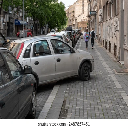


 Prediction Result:
  - Main Category: Road
  - Sub Category:  Issues Pothole
  - Confidence:    56.34%


In [ ]:

# --- Prediction Function (with corrections) ---
def predict_on_upload(model_to_use, train_gen):
    if model_to_use is None:
        print("Model is not loaded. Cannot predict.")
        return

    # Create the label map from the training generator
    class_indices = train_gen.class_indices
    labels_map = {v: k for k, v in class_indices.items()}

    # Upload files
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\n--- Analyzing '{filename}' ---")
        try:
            img = tf.keras.preprocessing.image.load_img(filename, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            anonymized_array = anonymize_image(img_array)
            img_batch = np.expand_dims(anonymized_array, axis=0)
            img_preprocessed = img_batch / 255.0
            prediction = model_to_use.predict(img_preprocessed)

            predicted_index = np.argmax(prediction[0])
            predicted_label = labels_map[predicted_index]
            confidence = np.max(prediction[0]) * 100

            main_category, sub_category = predicted_label.split('_', 1)

            print("\n Anonymized Input Image:")
            # CORRECTED LINE: Used COLOR_RGB2BGR
            display_img = cv2.cvtColor(anonymized_array, cv2.COLOR_RGB2BGR)
            cv2_imshow(display_img)

            print(f"\n Prediction Result:")
            print(f"  - Main Category: {main_category}")
            print(f"  - Sub Category:  {sub_category.replace('_', ' ')}")
            print(f"  - Confidence:    {confidence:.2f}%")
        except Exception as e:
            print(f" Error processing {filename}: {e}")


# --- Run Prediction ---
if best_model and 'train_generator' in locals():
    print("\nReady to predict! Use the button below to upload an image.")
    predict_on_upload(best_model, train_generator)
else:
    print("\nCannot run prediction. Ensure model was trained and data generators were created.")


Ready to predict! Use the button below to upload an image.


Saving images (5).jpg to images (5).jpg

--- Analyzing 'images (5).jpg' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

 Anonymized Input Image:


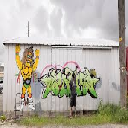


 Prediction Result:
  - Main Category: Vandalism
  - Sub Category:  Graffiti
  - Confidence:    98.08%


In [ ]:

# --- Prediction Function (with corrections) ---
def predict_on_upload(model_to_use, train_gen):
    if model_to_use is None:
        print("Model is not loaded. Cannot predict.")
        return

    # Create the label map from the training generator
    class_indices = train_gen.class_indices
    labels_map = {v: k for k, v in class_indices.items()}

    # Upload files
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\n--- Analyzing '{filename}' ---")
        try:
            img = tf.keras.preprocessing.image.load_img(filename, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            anonymized_array = anonymize_image(img_array)
            img_batch = np.expand_dims(anonymized_array, axis=0)
            img_preprocessed = img_batch / 255.0
            prediction = model_to_use.predict(img_preprocessed)

            predicted_index = np.argmax(prediction[0])
            predicted_label = labels_map[predicted_index]
            confidence = np.max(prediction[0]) * 100

            main_category, sub_category = predicted_label.split('_', 1)

            print("\n Anonymized Input Image:")
            # CORRECTED LINE: Used COLOR_RGB2BGR
            display_img = cv2.cvtColor(anonymized_array, cv2.COLOR_RGB2BGR)
            cv2_imshow(display_img)

            print(f"\n Prediction Result:")
            print(f"  - Main Category: {main_category}")
            print(f"  - Sub Category:  {sub_category.replace('_', ' ')}")
            print(f"  - Confidence:    {confidence:.2f}%")
        except Exception as e:
            print(f" Error processing {filename}: {e}")


# --- Run Prediction ---
if best_model and 'train_generator' in locals():
    print("\nReady to predict! Use the button below to upload an image.")
    predict_on_upload(best_model, train_generator)
else:
    print("\nCannot run prediction. Ensure model was trained and data generators were created.")


Ready to predict! Use the button below to upload an image.


Saving images (3).jpg to images (3).jpg

--- Analyzing 'images (3).jpg' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

 Anonymized Input Image:


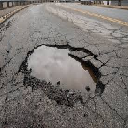


 Prediction Result:
  - Main Category: Road
  - Sub Category:  Issues Pothole
  - Confidence:    100.00%


In [ ]:

# --- Prediction Function (with corrections) ---
def predict_on_upload(model_to_use, train_gen):
    if model_to_use is None:
        print("Model is not loaded. Cannot predict.")
        return

    # Create the label map from the training generator
    class_indices = train_gen.class_indices
    labels_map = {v: k for k, v in class_indices.items()}

    # Upload files
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\n--- Analyzing '{filename}' ---")
        try:
            img = tf.keras.preprocessing.image.load_img(filename, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            anonymized_array = anonymize_image(img_array)
            img_batch = np.expand_dims(anonymized_array, axis=0)
            img_preprocessed = img_batch / 255.0
            prediction = model_to_use.predict(img_preprocessed)

            predicted_index = np.argmax(prediction[0])
            predicted_label = labels_map[predicted_index]
            confidence = np.max(prediction[0]) * 100

            main_category, sub_category = predicted_label.split('_', 1)

            print("\n Anonymized Input Image:")
            # CORRECTED LINE: Used COLOR_RGB2BGR
            display_img = cv2.cvtColor(anonymized_array, cv2.COLOR_RGB2BGR)
            cv2_imshow(display_img)

            print(f"\n Prediction Result:")
            print(f"  - Main Category: {main_category}")
            print(f"  - Sub Category:  {sub_category.replace('_', ' ')}")
            print(f"  - Confidence:    {confidence:.2f}%")
        except Exception as e:
            print(f" Error processing {filename}: {e}")


# --- Run Prediction ---
if best_model and 'train_generator' in locals():
    print("\nReady to predict! Use the button below to upload an image.")
    predict_on_upload(best_model, train_generator)
else:
    print("\nCannot run prediction. Ensure model was trained and data generators were created.")


Ready to predict! Use the button below to upload an image.


Saving images (8).jpg to images (8).jpg

--- Analyzing 'images (8).jpg' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

 Anonymized Input Image:


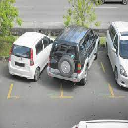


 Prediction Result:
  - Main Category: Parking
  - Sub Category:  Issues Illegal Parking
  - Confidence:    76.51%


In [ ]:

# --- Prediction Function (with corrections) ---
def predict_on_upload(model_to_use, train_gen):
    if model_to_use is None:
        print("Model is not loaded. Cannot predict.")
        return

    # Create the label map from the training generator
    class_indices = train_gen.class_indices
    labels_map = {v: k for k, v in class_indices.items()}

    # Upload files
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\n--- Analyzing '{filename}' ---")
        try:
            img = tf.keras.preprocessing.image.load_img(filename, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            anonymized_array = anonymize_image(img_array)
            img_batch = np.expand_dims(anonymized_array, axis=0)
            img_preprocessed = img_batch / 255.0
            prediction = model_to_use.predict(img_preprocessed)

            predicted_index = np.argmax(prediction[0])
            predicted_label = labels_map[predicted_index]
            confidence = np.max(prediction[0]) * 100

            main_category, sub_category = predicted_label.split('_', 1)

            print("\n Anonymized Input Image:")
            # CORRECTED LINE: Used COLOR_RGB2BGR
            display_img = cv2.cvtColor(anonymized_array, cv2.COLOR_RGB2BGR)
            cv2_imshow(display_img)

            print(f"\n Prediction Result:")
            print(f"  - Main Category: {main_category}")
            print(f"  - Sub Category:  {sub_category.replace('_', ' ')}")
            print(f"  - Confidence:    {confidence:.2f}%")
        except Exception as e:
            print(f" Error processing {filename}: {e}")


# --- Run Prediction ---
if best_model and 'train_generator' in locals():
    print("\nReady to predict! Use the button below to upload an image.")
    predict_on_upload(best_model, train_generator)
else:
    print("\nCannot run prediction. Ensure model was trained and data generators were created.")


Ready to predict! Use the button below to upload an image.


Saving Illegally-Parked-Car.jpg to Illegally-Parked-Car.jpg

--- Analyzing 'Illegally-Parked-Car.jpg' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

 Anonymized Input Image:


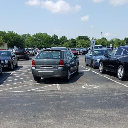


 Prediction Result:
  - Main Category: Parking
  - Sub Category:  Issues Illegal Parking
  - Confidence:    99.51%


In [ ]:

# --- Prediction Function (with corrections) ---
def predict_on_upload(model_to_use, train_gen):
    if model_to_use is None:
        print("Model is not loaded. Cannot predict.")
        return

    # Create the label map from the training generator
    class_indices = train_gen.class_indices
    labels_map = {v: k for k, v in class_indices.items()}

    # Upload files
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\n--- Analyzing '{filename}' ---")
        try:
            img = tf.keras.preprocessing.image.load_img(filename, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            anonymized_array = anonymize_image(img_array)
            img_batch = np.expand_dims(anonymized_array, axis=0)
            img_preprocessed = img_batch / 255.0
            prediction = model_to_use.predict(img_preprocessed)

            predicted_index = np.argmax(prediction[0])
            predicted_label = labels_map[predicted_index]
            confidence = np.max(prediction[0]) * 100

            main_category, sub_category = predicted_label.split('_', 1)

            print("\n Anonymized Input Image:")
            # CORRECTED LINE: Used COLOR_RGB2BGR
            display_img = cv2.cvtColor(anonymized_array, cv2.COLOR_RGB2BGR)
            cv2_imshow(display_img)

            print(f"\n Prediction Result:")
            print(f"  - Main Category: {main_category}")
            print(f"  - Sub Category:  {sub_category.replace('_', ' ')}")
            print(f"  - Confidence:    {confidence:.2f}%")
        except Exception as e:
            print(f" Error processing {filename}: {e}")


# --- Run Prediction ---
if best_model and 'train_generator' in locals():
    print("\nReady to predict! Use the button below to upload an image.")
    predict_on_upload(best_model, train_generator)
else:
    print("\nCannot run prediction. Ensure model was trained and data generators were created.")


Ready to predict! Use the button below to upload an image.


Saving images (9).jpg to images (9).jpg

--- Analyzing 'images (9).jpg' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

 Anonymized Input Image:


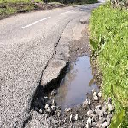


 Prediction Result:
  - Main Category: Road
  - Sub Category:  Issues Pothole
  - Confidence:    97.31%


In [ ]:

# --- Prediction Function (with corrections) ---
def predict_on_upload(model_to_use, train_gen):
    if model_to_use is None:
        print("Model is not loaded. Cannot predict.")
        return

    # Create the label map from the training generator
    class_indices = train_gen.class_indices
    labels_map = {v: k for k, v in class_indices.items()}

    # Upload files
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\n--- Analyzing '{filename}' ---")
        try:
            img = tf.keras.preprocessing.image.load_img(filename, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            anonymized_array = anonymize_image(img_array)
            img_batch = np.expand_dims(anonymized_array, axis=0)
            img_preprocessed = img_batch / 255.0
            prediction = model_to_use.predict(img_preprocessed)

            predicted_index = np.argmax(prediction[0])
            predicted_label = labels_map[predicted_index]
            confidence = np.max(prediction[0]) * 100

            main_category, sub_category = predicted_label.split('_', 1)

            print("\n Anonymized Input Image:")
            # CORRECTED LINE: Used COLOR_RGB2BGR
            display_img = cv2.cvtColor(anonymized_array, cv2.COLOR_RGB2BGR)
            cv2_imshow(display_img)

            print(f"\n Prediction Result:")
            print(f"  - Main Category: {main_category}")
            print(f"  - Sub Category:  {sub_category.replace('_', ' ')}")
            print(f"  - Confidence:    {confidence:.2f}%")
        except Exception as e:
            print(f" Error processing {filename}: {e}")


# --- Run Prediction ---
if best_model and 'train_generator' in locals():
    print("\nReady to predict! Use the button below to upload an image.")
    predict_on_upload(best_model, train_generator)
else:
    print("\nCannot run prediction. Ensure model was trained and data generators were created.")


Ready to predict! Use the button below to upload an image.


Saving traffic-signs-stop-sign-old-broken-sign-road-sign-traffic-notice-board-H3Y0YF.jpg to traffic-signs-stop-sign-old-broken-sign-road-sign-traffic-notice-board-H3Y0YF.jpg

--- Analyzing 'traffic-signs-stop-sign-old-broken-sign-road-sign-traffic-notice-board-H3Y0YF.jpg' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

 Anonymized Input Image:


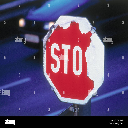


 Prediction Result:
  - Main Category: Road
  - Sub Category:  Issues Damaged Sign
  - Confidence:    67.91%


In [ ]:

# --- Prediction Function (with corrections) ---
def predict_on_upload(model_to_use, train_gen):
    if model_to_use is None:
        print("Model is not loaded. Cannot predict.")
        return

    # Create the label map from the training generator
    class_indices = train_gen.class_indices
    labels_map = {v: k for k, v in class_indices.items()}

    # Upload files
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\n--- Analyzing '{filename}' ---")
        try:
            img = tf.keras.preprocessing.image.load_img(filename, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            anonymized_array = anonymize_image(img_array)
            img_batch = np.expand_dims(anonymized_array, axis=0)
            img_preprocessed = img_batch / 255.0
            prediction = model_to_use.predict(img_preprocessed)

            predicted_index = np.argmax(prediction[0])
            predicted_label = labels_map[predicted_index]
            confidence = np.max(prediction[0]) * 100

            main_category, sub_category = predicted_label.split('_', 1)

            print("\n Anonymized Input Image:")
            # CORRECTED LINE: Used COLOR_RGB2BGR
            display_img = cv2.cvtColor(anonymized_array, cv2.COLOR_RGB2BGR)
            cv2_imshow(display_img)

            print(f"\n Prediction Result:")
            print(f"  - Main Category: {main_category}")
            print(f"  - Sub Category:  {sub_category.replace('_', ' ')}")
            print(f"  - Confidence:    {confidence:.2f}%")
        except Exception as e:
            print(f" Error processing {filename}: {e}")


# --- Run Prediction ---
if best_model and 'train_generator' in locals():
    print("\nReady to predict! Use the button below to upload an image.")
    predict_on_upload(best_model, train_generator)
else:
    print("\nCannot run prediction. Ensure model was trained and data generators were created.")


Ready to predict! Use the button below to upload an image.


Saving images (12).jpg to images (12).jpg

--- Analyzing 'images (12).jpg' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

 Anonymized Input Image:


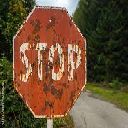


 Prediction Result:
  - Main Category: Road
  - Sub Category:  Issues Damaged Sign
  - Confidence:    98.78%


In [ ]:

# --- Prediction Function (with corrections) ---
def predict_on_upload(model_to_use, train_gen):
    if model_to_use is None:
        print("Model is not loaded. Cannot predict.")
        return

    # Create the label map from the training generator
    class_indices = train_gen.class_indices
    labels_map = {v: k for k, v in class_indices.items()}

    # Upload files
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\n--- Analyzing '{filename}' ---")
        try:
            img = tf.keras.preprocessing.image.load_img(filename, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            anonymized_array = anonymize_image(img_array)
            img_batch = np.expand_dims(anonymized_array, axis=0)
            img_preprocessed = img_batch / 255.0
            prediction = model_to_use.predict(img_preprocessed)

            predicted_index = np.argmax(prediction[0])
            predicted_label = labels_map[predicted_index]
            confidence = np.max(prediction[0]) * 100

            main_category, sub_category = predicted_label.split('_', 1)

            print("\n Anonymized Input Image:")
            # CORRECTED LINE: Used COLOR_RGB2BGR
            display_img = cv2.cvtColor(anonymized_array, cv2.COLOR_RGB2BGR)
            cv2_imshow(display_img)

            print(f"\n Prediction Result:")
            print(f"  - Main Category: {main_category}")
            print(f"  - Sub Category:  {sub_category.replace('_', ' ')}")
            print(f"  - Confidence:    {confidence:.2f}%")
        except Exception as e:
            print(f" Error processing {filename}: {e}")


# --- Run Prediction ---
if best_model and 'train_generator' in locals():
    print("\nReady to predict! Use the button below to upload an image.")
    predict_on_upload(best_model, train_generator)
else:
    print("\nCannot run prediction. Ensure model was trained and data generators were created.")